<a href="https://colab.research.google.com/github/McNickSisto/world_data_league/blob/activities/stage_4/mg_green_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

## Challenge Goals: 
Attracting people to green spaces in metropolitan areas is one of the most recent challenges for big cities. Encouraging people to spend more time in green spaces is one of the priority goals of municipal governments. It is fundamental to understand how various dimensions are linked to the search for green space in large Metropolitan Areas, such as in the metropolitan area of Porto and Lisbon. How can socio-demographic dimensions, tourist attraction, and people’s mobility level non-resident in the influence area of the green spaces explain the demand for these spaces?

## Outcome The challenge is composed of two outcomes:

Create a model that predicts the daily average demand of a green space and which factors contribute the most to the prediction—example of these factors: socio-demographic, touristic attraction points, mobility and others.

Based on the previous outcome, suggest action points that can be taken by the city hall to increase the usage of the green spaces in the city.

## Some info on the Data
Hello! The data refers to pre-pandemic period and the metrics represent daily average values. I think the size/area of each green space could be found after some research on the Web 



# Imports

In [45]:
! pip install geopandas --quiet
! pip install contextily --quiet
# ! pip install osmnx --quiet
# ! pip install osmium --quiet
! pip install osm-runner

You should consider upgrading via the '/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


You should consider upgrading via the '/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [131]:
import geopandas as gpd
import pandas as pd
import fiona
import os
import matplotlib.pyplot as plt
import folium
from zipfile import ZipFile
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.map import LayerControl, Layer, FeatureGroup
import seaborn as sns
from shapely.geometry import Point, LineString, MultiPoint
import requests
from io import BytesIO, StringIO
import contextily as ctx
from IPython.display import HTML, display, IFrame
import osmnx as ox
import osmium
from osm_runner import Runner
import regex as re
import unicodedata


In [47]:
# from google.colab import drive
# drive.mount('/gdrive')

# Data

In [48]:
green_areas = pd.read_csv('https://raw.githubusercontent.com/SowmyaMadala/WDL-Stage4/main/Data/Attracting%20Population/WDL_Green_Areas_Dataset_V1.txt', 
                          sep ="|", 
                          encoding ="latin-1").rename(columns = {'Number of Museums in influence area' : 'no_of_museums',
                                                                 'Number of parking lots in influence area' : 'no_of_parking_lots',
                                                                'Number of tourist attractions in influence area': 'no_of_tourist_attractions', 
                                                                'Green Zones Daily Average Demand':'gz_daily_avg_demand',
                                                                'Daily average of people in influence area': 'daily_avg_people',
                                                                'Number of buildings in influence area' : 'no_of_buildings',
                                                                'Number of families in influence area': 'no_of_families',
                                                                'Number of people resident in influence area' : 'no_of_people_resident'
                                                                })

green_areas.shape, green_areas.dtypes

((128, 14),
 Green_Zone_name               object
 no_of_museums                  int64
 no_of_parking_lots             int64
 no_of_tourist_attractions      int64
 gz_daily_avg_demand          float64
 Resident                       int64
 daily_avg_people             float64
 no_of_buildings                int64
 no_of_families                 int64
 no_of_people_resident          int64
 perc_senior_pop              float64
 perc_pop_until_19_yo         float64
 POINT_X                      float64
 POINT_Y                      float64
 dtype: object)

In [49]:
green_areas.head()

,Green_Zone_name,no_of_museums,no_of_parking_lots,no_of_tourist_attractions,gz_daily_avg_demand,Resident,daily_avg_people,no_of_buildings,no_of_families,no_of_people_resident,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y
0,ESPAÇO JOGO E RECREIO HOMEM DO LEME,5,28,30,3.728677,1,17780.803014,4783,15352,38012,0.195123,0.196017,-8.68415,41.16001
1,ESPAÇO JOGO E RECREIO HOMEM DO LEME,5,28,30,3.728677,0,45787.629298,4783,15352,38012,0.195123,0.196017,-8.68415,41.16001
2,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,0,42877.741202,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674
3,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,1,17497.825376,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674
4,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,8,23,4,47.347816,0,42877.741202,1775,17185,41163,0.161747,0.204917,-9.15757,38.75294


In [50]:
# Add relative demand for green spaces by population of influence area
green_areas['avg_rel_demand'] = green_areas.gz_daily_avg_demand / green_areas.daily_avg_people

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


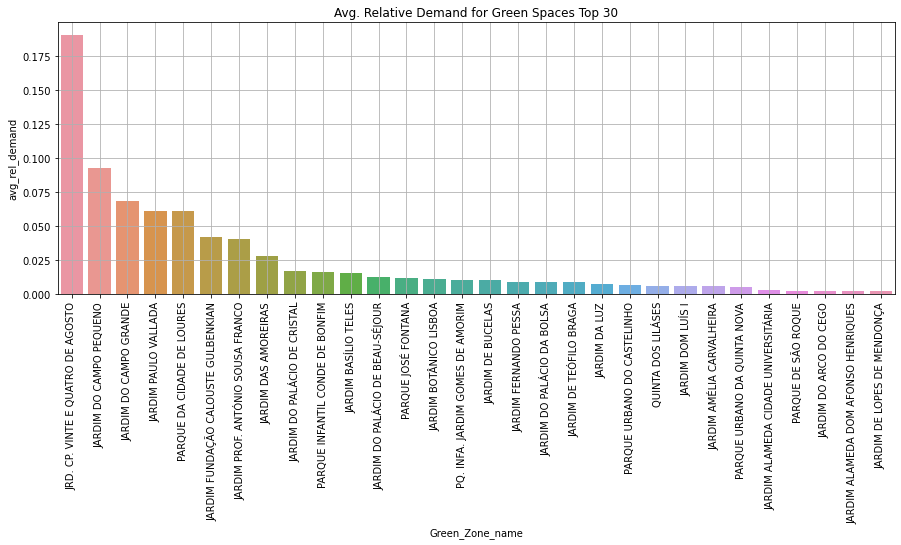

In [167]:
# plot top relative avg. daily demands for green areas for residents (!)
res_green_areas = green_areas[green_areas.Resident == 1]
res_green_areas = res_green_areas.sort_values(by='avg_rel_demand', ascending=False)
plt.figure(figsize=(15,5))
sns.barplot(x='Green_Zone_name', 
            y='avg_rel_demand', 
            data=res_green_areas.head(30),
            ci=None)
plt.xticks(rotation=90)
plt.title('Avg. Relative Demand for Green Spaces Top 30')
plt.grid()
plt.show()

In [52]:
# # make geo df and plot
# geo_green = gpd.GeoDataFrame(green_areas, geometry=gpd.points_from_xy(green_areas.POINT_X, green_areas.POINT_Y))
# geo_green.crs = "EPSG:3857"
# geo_green = geo_green.to_crs(epsg=3857)
# fig = plt.figure(figsize=(16,9))
# ax = plt.subplot()
# geo_green.plot(color='r', alpha=.3, ax=ax)
# ctx.add_basemap(ax = ax, source=ctx.providers.Stamen.Toner, zoom=13)

In [55]:
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
def mapa(la=True):
    m = folium.Map([40.16001, -8.68415], zoom_start=7)

    # marker_cluster = MarkerCluster(name='greenspaces')

    for c, row in res_green_areas.iterrows():
        x = row.POINT_X
        y = row.POINT_Y
        tooltip = row.Green_Zone_name
        radius = row.avg_rel_demand*300
        folium.CircleMarker((y,x), 
                      tooltip=tooltip,
                      popup=tooltip,
                      radius=radius, 
                      fill=True,
                      weight=0,
                      fill_opacity=.4,
                      fill_color='#FF0000'
                      ).add_to(m)

    # marker_cluster.add_to(m)
    html = m._repr_html_()
    width, height = (400,500) # width and height of the displayed iFrame, in pixels
    srcdoc = html.replace('"', '&quot;')
    embed = HTML(f'<iframe srcdoc="{srcdoc}" '
                 f'style="width: {width}px; height: {height}px; display:block; width: 100%; margin: 0 auto; '
                 f'border: none"></iframe>')

    return display(embed)

mapa()

# interact(mapa, la=IntSlider(min=5, max=21, step=1, value=8))

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


**Interpretation**<br>
It is visible that the most visited parks are very close to commercial centers and supermarkets. 
- JRD. CP. VINTE E QUATRO DE AGOSTO
- JARDIM DO CAMPO PEQUENO

# OSM features

## Find polygons of parks

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [143]:
# make latlng readable for OSM request
res_green_areas['latlng'] = res_green_areas.apply(lambda x: (x.POINT_Y, x.POINT_X), axis=1)

def get_parks(df):
    suggestions = pd.DataFrame()
    tags = {'leisure':True}
    for c, row in df.iterrows():
        center_point = row.latlng
        park = ox.geometries.geometries_from_point(center_point, 
                                                           tags=tags, 
                                                           dist=50)
        park['match'] = c # relate the findings to the dfs index (id)
        suggestions = pd.concat([suggestions, park])
        
    return suggestions

parks = get_parks(res_green_areas)

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [157]:
# group the findings by the first finding
by_match = parks.groupby('match').first() # the first one seems to be the park
by_match.head(4)

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [169]:
# merge the df with the matched 'parks' from the OSM request
res_green_areas = res_green_areas.merge(by_match['geometry'], how='left', left_index=True, right_index=True).sort_index()


In [212]:
geo_res_green_areas = gpd.GeoDataFrame(res_green_areas, geometry=res_green_areas.geometry_y)
# replace Nones with buffered points
geo_res_green_areas['geometry'] = geo_res_green_areas.apply(lambda x: x.geometry_x.buffer(.0007) if not x.geometry else x.geometry, axis=1)


/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [214]:
m = folium.Map([38.71, -9.2], zoom_start=11)
for c, row in geo_res_green_areas.iterrows():
    try:
        if row.geometry.type == 'Point':
            folium.Choropleth(row.geometry.buffer(.0007)).add_to(m)
        else: 
            folium.Choropleth(row.geometry).add_to(m)
    except:
        pass
m

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Find amenities

In [248]:
def get_amenities(df):
    insides_init = pd.DataFrame
    outsides_init = pd.DataFrame
    tags = {'amenity': True,
            'leisure': True,
            'tourism': True
           }
    for c, row in df.head().iterrows():
        poly = {c:row.geometry.exterior.coords.xy}
        outsides = ox.geometries.geometries_from_place(query=poly, 
                                                       tags=tags, 
                                                       buffer_dist=100)
        outsides['match'] = c
        outsides_init = pd.concat([outsides_init, outsides])
        
        insides = osmnx.geometries.geometries_from_polygon(poly, 
                                                           tags=tags)
        insides['match'] = c
        insides_init = pd.concat([insides_init, insides])
        
    return outsides, insides
        

In [249]:
outsides, insides = get_amenities(geo_res_green_areas)

ValueError: OSM returned no results for query "{0: (array('d', [-8.6854409, -8.6857011, -8.6857679, -8.6857946, -8.6858053, -8.6857002, -8.6856792, -8.6857749, -8.6856488, -8.6855881, -8.6855282, -8.6854036, -8.6852822, -8.6851446, -8.6851235, -8.6853033, -8.6852754, -8.6852444, -8.6850622, -8.6852332, -8.6850814, -8.6850044, -8.6849367, -8.6848853, -8.6848246, -8.6847573, -8.6847114, -8.6846624, -8.6846403, -8.684557, -8.6844637, -8.6843617, -8.6841685, -8.6841549, -8.6841708, -8.6854409]), array('d', [41.1619784, 41.1618896, 41.161849, 41.1617724, 41.1617417, 41.1615413, 41.1614112, 41.1612003, 41.1610614, 41.1610298, 41.1608267, 41.1608608, 41.1606525, 41.1606965, 41.1606606, 41.1605962, 41.1605435, 41.1605511, 41.160186, 41.1601473, 41.1597183, 41.15959, 41.159539, 41.1595247, 41.1595127, 41.1595081, 41.1595139, 41.1595221, 41.159542, 41.1595449, 41.1595397, 41.1595714, 41.1596357, 41.1596761, 41.1597289, 41.1619784]))}"

In [ ]:
# focus on residents (the data suggests that we should look there)
## non residential factors could be blowing the scope (touristic influences)

'''
- bus stops
- cafes/restaurants
- supermarkets/shops
- amount of park benches
- trash bins
- big streets
- dog areas
- dog ownership in the sorrounding
- skate park / sport activities
- amount of trees
'''

- Split data set for old and young ppl
  - not all old ppl want skate parks
  